# Tutorial 3. Use SEDR to do batch integration.

Here we use 3 sections from DLPFC data to show the ability of SEDR to integrate batches for the same tissue with the same techniques. 

In [24]:
import os
import torch
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
from tqdm import tqdm

In [2]:
import SEDR

In [3]:
data_root = Path('../data/DLPFC/')

proj_list = [
    '151673', '151674', '151675'
]

## Combining datasets

Input of SEDR includes an AnnData object that contains the spatial transcriptomics data and a graph dictionary that contains the neighborhood graph. When combining two datasets, the AnnData objects are directly concatenated. For neighborhood graphs, we follow the following algorithm.  
Let $A^k$ and $Z_f^k$ denote the adjacency matrix and deep gene representation of spatial omics k, we then create a block-diagonal adjacency matrix $A^k$  and concatenate the deep gene representation in the spot dimension, as:  
![](batch_integration.png)  
where K is the number of spatial omics. 


In [4]:
for proj_name in tqdm(proj_list):
    adata_tmp = sc.read_visium(data_root / proj_name)
    adata_tmp.var_names_make_unique()

    adata_tmp.obs['batch_name'] = proj_name
    graph_dict_tmp = SEDR.graph_construction(adata_tmp, 12)
    
    ##### Load layer_guess label, if have
    df_label = pd.read_csv(data_root / proj_name / 'metadata.tsv', sep='\t')
    adata_tmp.obs['layer_guess'] = df_label['layer_guess']
    adata_tmp= adata_tmp[~pd.isnull(adata_tmp.obs['layer_guess'])]
    
    if proj_name == proj_list[0]:
        adata = adata_tmp
        graph_dict = graph_dict_tmp
        name = proj_name
        adata.obs['proj_name'] = proj_name
    else:
        var_names = adata.var_names.intersection(adata_tmp.var_names)
        adata = adata[:, var_names]
        adata_tmp = adata_tmp[:, var_names]
        adata_tmp.obs['proj_name'] = proj_name
    
        adata = adata.concatenate(adata_tmp)
        graph_dict = SEDR.combine_graph_dict(graph_dict, graph_dict_tmp)
        name = name + '_' + proj_name

100%|██████████| 3/3 [02:05<00:00, 41.93s/it]


## Preprocessing

In [5]:
adata.layers['count'] = adata.X.toarray()
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.filter_genes(adata, min_counts=10)
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", layer='count', n_top_genes=2000)
adata = adata[:, adata.var['highly_variable'] == True]
sc.pp.scale(adata)

from sklearn.decomposition import PCA  # sklearn PCA is used because PCA in scanpy is not stable. 
adata_X = PCA(n_components=200, random_state=42).fit_transform(adata.X)
adata.obsm['X_pca'] = adata_X

## Training SEDR

In [6]:
sedr_net = SEDR.Sedr(adata.obsm['X_pca'], graph_dict, mode='clustering', device='cuda:2')
using_dec = False
if using_dec:
    sedr_net.train_with_dec()
else:
    sedr_net.train_without_dec()
sedr_feat, _, _, _ = sedr_net.process()
adata.obsm['SEDR'] = sedr_feat

100%|██████████| 200/200 [00:29<00:00,  6.83it/s]


## use harmony to calculate revised PCs

In [14]:
import harmonypy as hm

meta_data = adata.obs[['batch']]

data_mat = adata.obsm['SEDR']
vars_use = ['batch']
ho = hm.run_harmony(data_mat, meta_data, vars_use)

res = pd.DataFrame(ho.Z_corr).T
res_df = pd.DataFrame(data=res.values, columns=['X{}'.format(i+1) for i in range(res.shape[1])], index=adata.obs.index)
adata.obsm[f'SEDR.Harmony'] = res_df

2023-10-02 11:18:12,622 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-10-02 11:18:15,358 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-10-02 11:18:15,610 - harmonypy - INFO - Iteration 1 of 10
2023-10-02 11:18:17,742 - harmonypy - INFO - Iteration 2 of 10
2023-10-02 11:18:19,798 - harmonypy - INFO - Iteration 3 of 10
2023-10-02 11:18:22,020 - harmonypy - INFO - Iteration 4 of 10
2023-10-02 11:18:24,260 - harmonypy - INFO - Iteration 5 of 10
2023-10-02 11:18:26,402 - harmonypy - INFO - Iteration 6 of 10
2023-10-02 11:18:28,435 - harmonypy - INFO - Iteration 7 of 10
2023-10-02 11:18:30,466 - harmonypy - INFO - Converged after 7 iterations


## Visualizing

### UMAP

In [15]:
sc.pp.neighbors(adata, use_rep='SEDR.Harmony', metric='cosine')
sc.tl.umap(adata)

[<Axes: title={'center': 'layer_guess'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'batch_name'}, xlabel='UMAP1', ylabel='UMAP2'>]

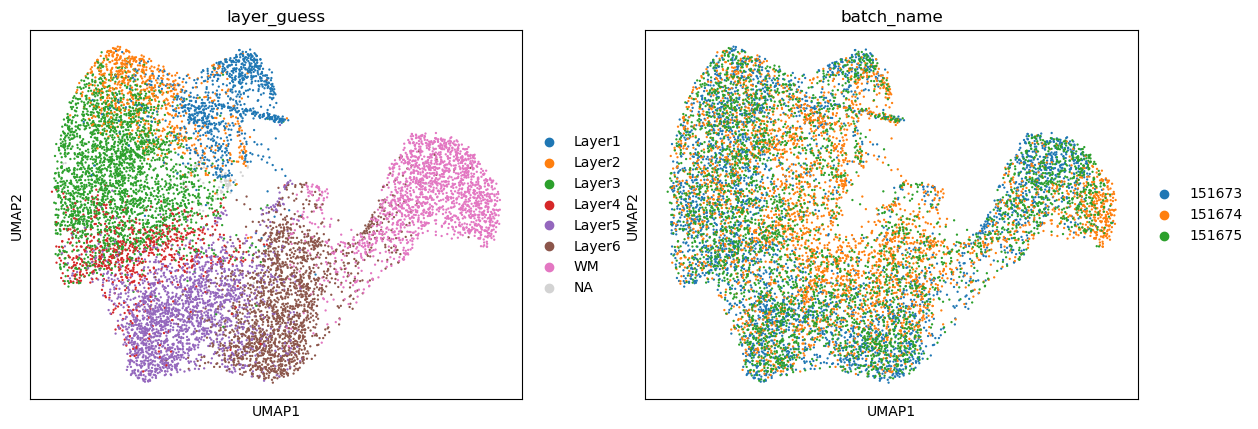

In [16]:
sc.pl.umap(adata, color=['layer_guess', 'batch_name'], show=False)

### LISI score

In [34]:
ILISI = hm.compute_lisi(adata.obsm['SEDR.Harmony'], adata.obs[['batch']], label_colnames=['batch'])[:, 0]
CLISI = hm.compute_lisi(adata.obsm['SEDR.Harmony'], adata.obs[['layer_guess']], label_colnames=['layer_guess'])[:, 0]

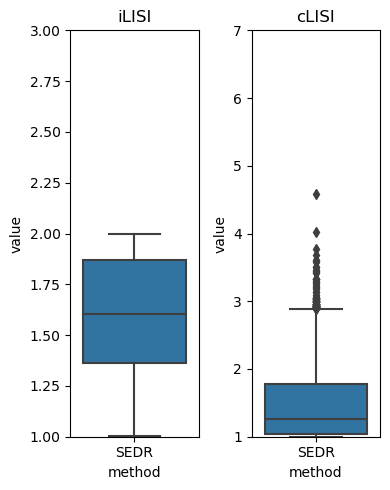

In [38]:
df_ILISI = pd.DataFrame({
    'method': 'SEDR',
    'value': ILISI,
    'type': ['ILISI']*len(ILISI)
})


df_CLISI = pd.DataFrame({
    'method': 'SEDR',
    'value': CLISI,
    'type': ['CLISI']*len(CLISI)
})

fig, axes = plt.subplots(1,2,figsize=(4, 5))
sns.boxplot(data=df_ILISI, x='method', y='value', ax=axes[0])
sns.boxplot(data=df_CLISI, x='method', y='value', ax=axes[1])
axes[0].set_ylim(1, 3)
axes[1].set_ylim(1, 7)
axes[0].set_title('iLISI')
axes[1].set_title('cLISI')

plt.tight_layout()